In [2]:
import cv2
import numpy as np
import json
from matplotlib import pyplot as plt
import os
import random
import torch
from sahi.utils.coco import Coco, CocoCategory, CocoImage, CocoAnnotation
from sahi.utils.file import save_json
import pandas as pd
%matplotlib inline

d:\Programming\hacks\Polyus-Hack-2022-RealityX-ML\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.cuda.is_available()

False

In [4]:
Y_CROP = (240, 720)
X_CROP = (200, 900)
SIZE = (X_CROP[1] - X_CROP[0], Y_CROP[1] - Y_CROP[0])

In [5]:
def get_frame_id(image_name: str) -> str:
    return image_name[5:-4]

In [6]:
def translate_bbox(bbox):
    x, y, w, h = bbox
    x = round(x - X_CROP[0], 3)
    y = round(y - Y_CROP[0], 3)
    return (x, y, w, h)

In [7]:
def normalize_bbox(bbox):
    x, y, w, h = bbox
    im_w, im_h = SIZE
    return ((x + w / 2) / im_w, (y + h / 2) / im_h, w / im_w, h / im_h)

In [8]:
def rescale_bbox(bbox):
    x, y, w, h = bbox
    im_w, im_h = SIZE
    x = int(round((x - w / 2) * im_w + X_CROP[0]))
    y = int(round((y - h / 2) * im_h + Y_CROP[0]))
    w = int(round(w * im_w))
    h = int(round(h * im_h))
    return (x, y, w, h)

In [9]:
def get_bbox_dict():
    bbox_dict = {}
    with open(r'./dataset/annot_local/train_annotation.json', 'r') as f:
        annotations = json.load(f)['annotations']
    for annotation in annotations:
        id = annotation['image_id']
        bboxes = bbox_dict.get(id, [])
        bbox = annotation['bbox']
        bbox = translate_bbox(bbox)
        if bbox[0] < 0 or bbox[1] < 0 or bbox[0] + bbox[2] > SIZE[0] or bbox[1] + bbox[3] > SIZE[1]:
            continue
        bbox = normalize_bbox(bbox)
        bboxes.append(bbox)
        bbox_dict[id] = bboxes
    return bbox_dict

In [28]:
def process_image(image_path: str):
    image = cv2.imread(image_path)
    image = image[Y_CROP[0]:Y_CROP[1], X_CROP[0]:X_CROP[1]]
    image = cv2.fastNlMeansDenoisingColored(image,None,7,1,5,8)
    return image

In [75]:
train_ids = list(get_bbox_dict().keys())
for id in train_ids:
    img = process_image(f'./dataset/train/frame{id}.jpg')
    cv2.imwrite(f'./only_train/frame{id}.jpg', img)

./dataset/train/frame1.jpg


TypeError: 'NoneType' object is not subscriptable

In [11]:
def write_image_label(id, bboxes, root_dir, path):
    image = process_image(f'dataset\\train\\frame{id}.jpg')
    cv2.imwrite(os.path.join(root_dir, 'images', path, f'{id}.png'), image)
    lines = []
    for bbox in bboxes:
        lines.append('0 ' + ' '.join([str(round(x, 5)) for x in bbox]))
    lines = '\n'.join(lines)
    with open(os.path.join(root_dir, 'labels', path, f'{id}.txt'), 'w') as file:
        file.write(lines)


In [12]:
def create_folders(root_path):
    for a in ['images', 'labels']:
        for b in ['train', 'test']:
            os.makedirs(os.path.join(root_path, a, b), exist_ok=True)

In [13]:
def create_dataset(root_path: str, split_rate: float = 0.7):
    create_folders(root_path)
    bboxes_dict = get_bbox_dict()
    ids = list(bboxes_dict.keys())
    # random.shuffle(ids)
    split_index = int(len(ids) * split_rate)
    test_ids = ids[split_index:]
    for id, bboxes in bboxes_dict.items():
        path = 'train'
        if id in test_ids:
            path = 'test'
        write_image_label(id, bboxes, root_path, path)

In [185]:
create_dataset('dataset_not_random', 0.7)

In [14]:
TOLERANCE = 50
Y_MID_POINT = 440
LINE_MID = (800, 250)

def fuse(intersections: list):
    fused = [intersections[0]]
    intersections = intersections[1:]
    for intersec in intersections:
        if fused[-1][1] >= intersec[0]:
            fused[-1] = (min(fused[-1][0], intersec[0]), max(fused[-1][1], intersec[1]))
        else:
            fused.append(intersec)
    return fused

def get_fullness(intersection_points):
    intersection_points.sort(key=lambda x: x[0])
    intersection_points = fuse(intersection_points)
    fullness = sum([x[1] - x[0] for x in intersection_points]) / (LINE_MID[0] - LINE_MID[1] - TOLERANCE * 2)
    return fullness


In [15]:
TOLERANCE = 50

def get_bbox_img(id: int, line_h: int=-1):
    width = 780-250
    intersection_points = []
    image = cv2.imread(f'dataset\\train\\frame{id}.jpg')
    with open(r'./dataset/annot_local/train_annotation.json', 'r') as f:
        annotations = json.load(f)['annotations']
    bboxes = [x['bbox'] for x in annotations if x['image_id'] == id]
    for x, y, w, h in bboxes:
        x = round(x)
        y = round(y)
        w = round(w)
        h = round(h)
        if y < line_h and y + h > line_h:
            intersection_points.append((x, x + w))
        cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    intersection_points.sort(key=lambda x: x[0])
    intersection_points = fuse(intersection_points)
    fullness = sum([x[1] - x[0] for x in intersection_points]) / (780 - 250 - TOLERANCE * 2)
    print(fullness)
    if (h > 0):
        cv2.line(image, (250 + TOLERANCE, line_h), (780 - TOLERANCE, line_h), (255, 0, 255), 3)
    image = image[Y_CROP[0]:Y_CROP[1], X_CROP[0]:X_CROP[1]]
    print(image.shape)
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    plt.title('my picture')
    plt.axis('off')
    plt.show()
    
    

0.6255813953488372
(420, 640, 3)


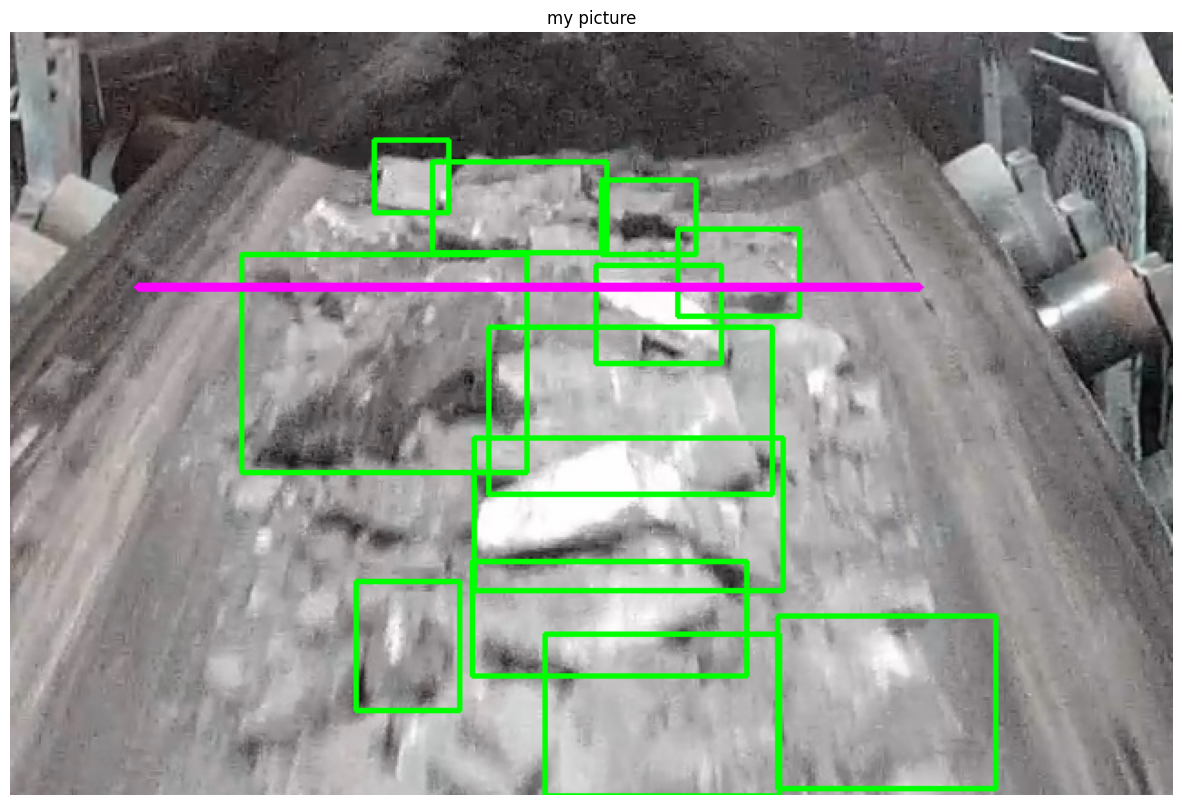

In [177]:
get_bbox_img(149, 440)

In [27]:
os.mkdir('vids_data')
for img_path in os.listdir(r'./vid_test'):
    image = process_image(os.path.join(r'./vid_test/', img_path))
    cv2.imwrite(os.path.join(r'./vids_data/', img_path), image)
    

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)


## Посылка

In [187]:
path = r'./dataset_not_random/images/test/'
coco = Coco(image_id_setting='manual')
coco.add_category(CocoCategory(id=0, name='stone0'))
coco.add_category(CocoCategory(id=1, name='stone1'))
bbox_dict = get_bbox_dict()
bboxes_path = os.listdir(path)
for bbox_filepath in bboxes_path:
    id = int(bbox_filepath[:-4])
    coco_image = CocoImage(file_name=f'./dataset/train/frame{id}.jpg', height=720, width=1280, id=id)
    bboxes = bbox_dict[id]
    for bbox in bboxes:
        bbox = rescale_bbox(bbox)
        coco_image.add_annotation(
                                CocoAnnotation(
                                bbox=bbox,
                                category_id=1,
                                category_name='stone1',
                                image_id=id
                                )
                            )
    coco.add_image(coco_image)
# print(coco.json)
save_json(data=coco.json, save_path=r'./our_annotation.json')

In [116]:
write_files = False
path = r'./yolov5/runs/detect/exp57/labels'
coco = Coco()
coco.add_category(CocoCategory(id=0, name='stone0'))
coco.add_category(CocoCategory(id=1, name='stone1'))
bboxes = os.listdir(path)
for bbox_filepath in bboxes:
    id = int( get_frame_id(bbox_filepath))
    coco_image = CocoImage(file_name=f'./dataset/train/frame{id}.jpg', height=720, width=1280, id=id)
    if write_files:
        image = cv2.imread(f'./dataset/train/frame{id}.jpg')
    
    with open(os.path.join(path, bbox_filepath)) as f:
        for line in f:
            bbox = [float(x.strip()) for x in line.split(' ')[1:]]
            bbox = rescale_bbox(bbox)
            if write_files:
                x, y, w,h = bbox
                cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
            coco_image.add_annotation(
                                CocoAnnotation(
                                bbox=bbox,
                                category_id=1,
                                category_name='stone1',
                                image_id=id
                                )
                            )
    if write_files:
        cv2.imwrite(f'tmp/bboxes/frame{id}.jpg', image)
    coco.add_image(coco_image)
# print(coco.json)
save_json(data=coco.json, save_path=r'./tmp/posilka.json')

## Тест

In [112]:
def closest_node(node, nodes):
    # Получение индекса ближайшей точки
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node) ** 2, axis = 1)
    return np.argmin(dist_2)

def get_all(true_bboxs: np.ndarray, pred_bboxs: np.ndarray):
    # Базовый расчет FP, FN
    # Получение ближайших центров квадратов для всех пар
    true = np.array([true_bboxs[:,0]+true_bboxs[:,2]/2, true_bboxs[:,1]+true_bboxs[:,3]/2]).T
    # print(pred_bboxs)
    pred = np.array([pred_bboxs[:,0]+pred_bboxs[:,2]/2, pred_bboxs[:,1]+pred_bboxs[:,3]/2]).T
    
    true_cnt, pred_cnt = true.shape[0], pred.shape[0]
    if true_cnt < pred_cnt:
        FP = pred_cnt-true_cnt
        FN = 0
    elif true_cnt > pred_cnt:
        FN = true_cnt-pred_cnt
        FP = 0
    else:
        FP = FN = 0
    closet_inds = []
    if FP>=FN:
        for i in true:
            closet_inds.append(closest_node(i, pred))
    else:
        for i in pred:
            closet_inds.append(closest_node(i, true))
    return closet_inds, FP, FN

def bb_intersection_over_union(boxA_:np.ndarray, boxB_:np.ndarray):
    # Расчет IoU
    boxA, boxB = boxA_.copy(), boxB_.copy()
    # Корректировка формата (x,y,w,h) -> (x1,y1,x2,y2)
    boxA[2], boxB[2], boxA[3], boxB[3] = boxA[0]+boxA[2], boxB[0]+boxB[2], boxA[1]+boxA[3], boxB[1]+boxB[3]
    
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

# Юзать этот метод, он принимает два файла, который являются байтовыми словарями
def run(bytes_str_true, bytes_str_sub):
  annot = json.loads(bytes_str_true.decode("utf-8").replace("'",'"'))

  df_images_true = pd.DataFrame(annot['images'])
  df_annot_true = pd.DataFrame(annot['annotations'])

  annot = json.loads(bytes_str_sub.decode("utf-8").replace("'",'"'))

  df_images_sub = pd.DataFrame(annot['images'])
  df_annot_sub = pd.DataFrame(annot['annotations'])
  print(df_images_true.shape, df_images_sub.shape)


  # обрабатываем ситуацию, когда пара file_name -- id
  # не соответствует в оригинальных и прогнозных файлах
  # df_images_true = df_images_true.set_index('file_name').sort_index()
  # df_images_sub = df_images_sub.set_index('file_name').sort_index()

  # df_images_sub.loc[:,'id']=df_images_true['id'].values


  iou=[]
  FP = FN =  0
  # Внешний цикл, проходит по всем кадрам
  for img_id in df_images_true['id'].values:
      true = np.array(list(df_annot_true[df_annot_true['image_id']==img_id]['bbox'].values))
      pred = np.array(list(df_annot_sub[df_annot_sub['image_id']==img_id]['bbox'].values))
      
      coord_inds, FP, FN = get_all(true, pred)
      # Внутренний цикл, считает IoU для пар
      for i,j in enumerate(coord_inds):
          if FN>+FP:
              iou.append(bb_intersection_over_union(true[j], pred[i]))
          else:
              iou.append(bb_intersection_over_union(pred[j], true[i]))
  iou = np.array(iou)
  FP += np.sum(iou<=0.5)
  TP = np.sum(iou>0.5)
  mIoU=np.mean(iou)
  beta = 2
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  fb = (((1+beta**2)*precision*recall)/((beta**2)*precision+recall))*mIoU
  print("Final score: ",fb) # ИТоговый результат метрики

def getScoreSubmission(submission_path):
    # загружаем оригинальные аннотации json и забираем необходимые части
    f = open('./our_annotation.json')
    annot = json.load(f)
    f.close()
    bytes_str_true = json.dumps(annot, indent=2).encode('utf-8') 

    # загружаем прогнозные аннотации json и забираем необходимые части
    f = open(submission_path)
    annot = json.load(f)
    bytes_str_sub = json.dumps(annot, indent=2).encode('utf-8')
    f.close()
    run(bytes_str_true, bytes_str_sub)


In [113]:
getScoreSubmission("./tmp/posilka.json")

(390, 4) (390, 4)
Final score:  0.7760787726555607
